# Imports

In [1]:
import os
import re

import emoji
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

pd.set_option('display.max_colwidth', 100) 

# Read Data

In [2]:
ch_sample_link = '/data/ch_sample_selections_data.csv'
cg_sample_link = '/data/sample_wsb_gme_personalfin_stock.csv'
rr_sample_link = '/data/forex_finance_finindependence_forex.csv'

file_links = [ch_sample_link, cg_sample_link, rr_sample_link]

In [3]:
ch_sample = pd.read_csv(os.getcwd() + ch_sample_link)
cg_sample = pd.read_csv(os.getcwd() + cg_sample_link)
rr_sample = pd.read_csv(os.getcwd() + rr_sample_link)

In [4]:
print(ch_sample.shape, cg_sample.shape, rr_sample.shape)

(15000, 25) (16000, 25) (6104, 25)


In [5]:
# datatypes match
pd.concat([ch_sample.dtypes,cg_sample.dtypes,rr_sample.dtypes],axis=1)

,0,1,2
Unnamed: 0,int64,int64,int64
id,object,object,object
author,object,object,object
created,object,object,object
retrieved,object,object,object
edited,object,object,object
pinned,int64,int64,int64
archived,int64,int64,int64
locked,int64,int64,int64
removed,int64,int64,int64


In [6]:
def read_files(file_links):
    df = pd.DataFrame()
    for link in file_links:
        df = pd.concat((df, pd.read_csv(os.getcwd() + link)), axis=0)
    return df

In [7]:
df_full_raw = read_files(file_links)

In [8]:
np.random.seed(42)
indices = np.arange(len(df_full_raw))
shuffled_indices = np.random.permutation(indices)
df_full = df_full_raw.iloc[shuffled_indices]

# Split Data for EDA

In [9]:
Y_full = df_full['score']
X_full = df_full.drop(columns='score')

In [10]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[['Unnamed: 0', 'id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink']]

    Y_full = df_full['score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0])
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [12]:
df = pd.concat((X_train, y_train), axis=1)

In [13]:
df.shape

(25972, 25)

# Examine Training Data

In [14]:
df.shape

(25972, 25)

In [15]:
df.isna().sum()

Unnamed: 0                  0
id                          0
author                      0
created                     0
retrieved                   0
edited                      0
pinned                      0
archived                    0
locked                      0
removed                     0
deleted                     0
is_self                     0
is_video                    0
is_original_content         0
title                       0
link_flair_text          6361
upvote_ratio                0
gilded                      0
total_awards_received       0
num_comments                0
num_crossposts              0
selftext                    1
thumbnail                   0
shortlink                   0
score                       0
dtype: int64

### Dropping Null selftext values

In [16]:
print(df.shape)
df = df.dropna(subset='selftext')
print(df.shape)

(25972, 25)
(25971, 25)


### Filling NA's for link_flair_text

In [17]:
df[df['link_flair_text'].isna()].fillna({'link_flair_text':''}).iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
5077,7053,pcjlxl,AutoModerator,2021-08-27 09:00:15,2021-08-27 17:18:21,1970-01-01 00:00:00,0,0,0,0,...,,0.67,0,0,26,0,\n\nPlease use this thread to discuss how amazingly cheap you are. How do you keep your costs...,self,https://redd.it/pcjlxl,3
11878,1878,lvuyxi,Outside-South5454,2021-03-02 05:41:06,2021-03-02 18:08:23,1970-01-01 00:00:00,0,0,0,0,...,,0.83,0,0,9,0,Q4 Results :\n\nRevenue : 882 M (369 % increase) \n\nNet profit : 260 M (1599% increase) \n\nFis...,self,https://redd.it/lvuyxi,26


In [18]:
df.describe()

,Unnamed: 0,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score
count,25971.000000,25971.0,25971.0,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000,25971.000000
mean,63150.673520,0.0,0.0,0.001540,0.017943,0.015248,0.984752,0.000077,0.002772,0.776895,0.025220,0.772438,64.774287,0.068653,96.962458
std,133391.188722,0.0,0.0,0.039216,0.132747,0.122539,0.122539,0.008775,0.052581,0.199641,0.705566,8.981509,920.371051,0.544606,1299.452294
min,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2134.500000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.670000,0.000000,0.000000,3.000000,0.000000,1.000000
50%,4346.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,8.000000,0.000000,5.000000
75%,63747.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.950000,0.000000,0.000000,21.000000,0.000000,19.000000
max,774865.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,108.000000,472.000000,72564.000000,48.000000,138766.000000


Remove the "Unnamed: 0" field

In [19]:
df.iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
12827,23611,llz8a2,RoofNRun,2021-02-17 17:06:32,2021-02-18 05:36:29,1970-01-01 00:00:00,0,0,0,0,...,Company Discussion,0.81,0,0,1,0,BIDU FSLY TWLO FVRR DBX WMT SQ \n\nSo I’ve got these companies on my list for upcoming earnings ...,self,https://redd.it/llz8a2,6
2075,351473,lblofg,lenz1002,2021-02-03 11:35:03,2021-02-04 22:02:21,2021-02-03 15:19:30,0,0,0,0,...,Discussion,0.96,1,16,601,1,It's not rocket science.\n\nRobinhood's imposed buy limits coincide perfectly with $GME's stock ...,self,https://redd.it/lblofg,7030


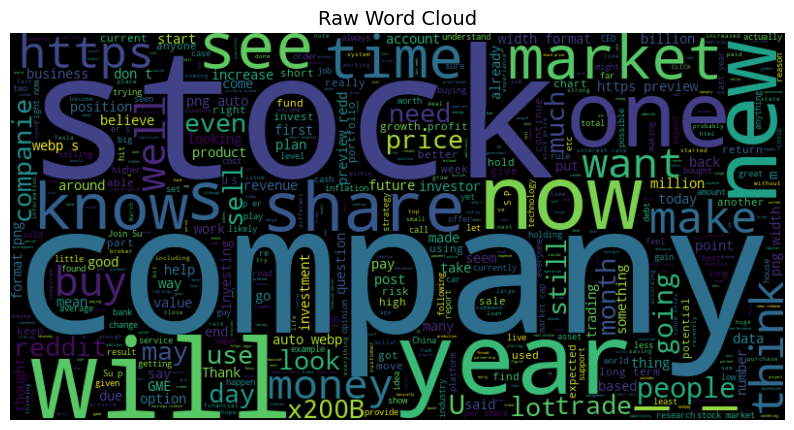

In [20]:
plt.figure(figsize=(10, 10))
words = " ".join(df['selftext'])
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Raw Word Cloud', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

### Reviewing unexpected terms, such as https, webp, pgn.

Where are these words coming from?

In [21]:
search_terms = [r'https', r'webp','png']

The search terms are all part of url's. They will be removed.

In [22]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].iloc[0]

"It's not rocket science.\n\nRobinhood's imposed buy limits coincide perfectly with $GME's stock plummeting.\n\nIf the demand for stock is: buying it > selling it, it rises.\n\nIf it's selling it > buying it, it plummets. And $GME is plummeting because of Robinhood's buying restrictions.\n\nThe only hurdle right now is Robinhood's decision to limit $GME share purchases. But everyone is either against or on that case ([Sherrod Brown](https://twitter.com/SenSherrodBrown/status/1354881250922819585?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1354881250922819585%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.cnet.com%2Fpersonal-finance%2Faoc-and-lawmakers-call-for-hearings-on-robinhood-for-freezing-trades-on-gamestop-stock%2F), [Ted Cruz](https://twitter.com/tedcruz/status/1354833603943931905?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1354833603943931905%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.cnet.com%2Fpersonal-finance%2Faoc-and-lawmakers-call-for-hearings-

In [23]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).iloc[0]

"It's not rocket science.\n\nRobinhood's imposed buy limits coincide perfectly with $GME's stock plummeting.\n\nIf the demand for stock is: buying it > selling it, it rises.\n\nIf it's selling it > buying it, it plummets. And $GME is plummeting because of Robinhood's buying restrictions.\n\nThe only hurdle right now is Robinhood's decision to limit $GME share purchases. But everyone is either against or on that case ([Sherrod Brown](<url>), [Ted Cruz](<url>), [Attorney General James](<url>), [AOC](<url>), [Elon Musk](<url>)).\n\nAs long as you don't sell your shares, the sky-fucking-high demand for $GME right NOW is gonna skyrocket its prices—it's garnering worldwide attention.\n\nSo hold, even if it's one share. 💎🙌\n\n&#x200B;\n\nEdit (Feb 4, 15:19 GMT) : The logic definitely is over simplified, but I wanted to be short and to the point. Couching my point with a bunch of esoteric financial terms is only gonna obscure what I'm trying to say. Robinhood definitely isn't the only reason t

Remove URL's, and replace with "< url >"

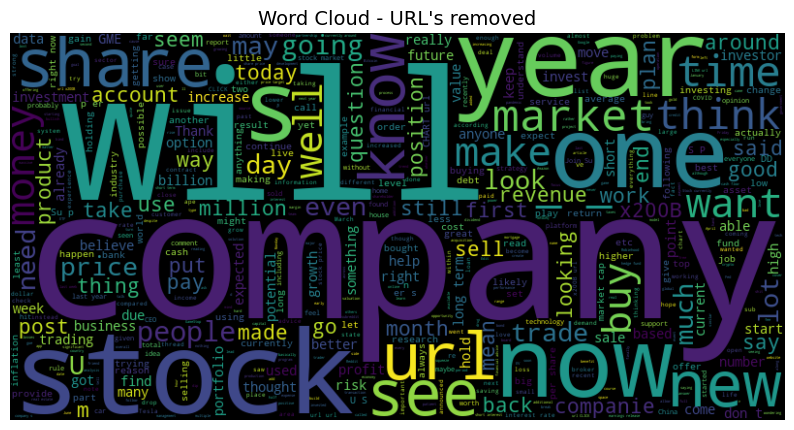

In [24]:
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's removed", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [25]:
# Identifying x200b, which is zero width space
search_terms = ['x200']
zero_width_indexes = df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))
df[zero_width_indexes]['selftext'].iloc[0][:1000]

"It's not rocket science.\n\nRobinhood's imposed buy limits coincide perfectly with $GME's stock plummeting.\n\nIf the demand for stock is: buying it > selling it, it rises.\n\nIf it's selling it > buying it, it plummets. And $GME is plummeting because of Robinhood's buying restrictions.\n\nThe only hurdle right now is Robinhood's decision to limit $GME share purchases. But everyone is either against or on that case ([Sherrod Brown](https://twitter.com/SenSherrodBrown/status/1354881250922819585?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1354881250922819585%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.cnet.com%2Fpersonal-finance%2Faoc-and-lawmakers-call-for-hearings-on-robinhood-for-freezing-trades-on-gamestop-stock%2F), [Ted Cruz](https://twitter.com/tedcruz/status/1354833603943931905?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1354833603943931905%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.cnet.com%2Fpersonal-finance%2Faoc-and-lawmakers-call-for-hearings-

In [26]:
# Remove zero width spaces (x200B)
df[zero_width_indexes]['selftext'].apply(lambda x: re.sub(r'x200B', '', x)).iloc[0][:1000]

"It's not rocket science.\n\nRobinhood's imposed buy limits coincide perfectly with $GME's stock plummeting.\n\nIf the demand for stock is: buying it > selling it, it rises.\n\nIf it's selling it > buying it, it plummets. And $GME is plummeting because of Robinhood's buying restrictions.\n\nThe only hurdle right now is Robinhood's decision to limit $GME share purchases. But everyone is either against or on that case ([Sherrod Brown](https://twitter.com/SenSherrodBrown/status/1354881250922819585?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1354881250922819585%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.cnet.com%2Fpersonal-finance%2Faoc-and-lawmakers-call-for-hearings-on-robinhood-for-freezing-trades-on-gamestop-stock%2F), [Ted Cruz](https://twitter.com/tedcruz/status/1354833603943931905?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1354833603943931905%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.cnet.com%2Fpersonal-finance%2Faoc-and-lawmakers-call-for-hearings-

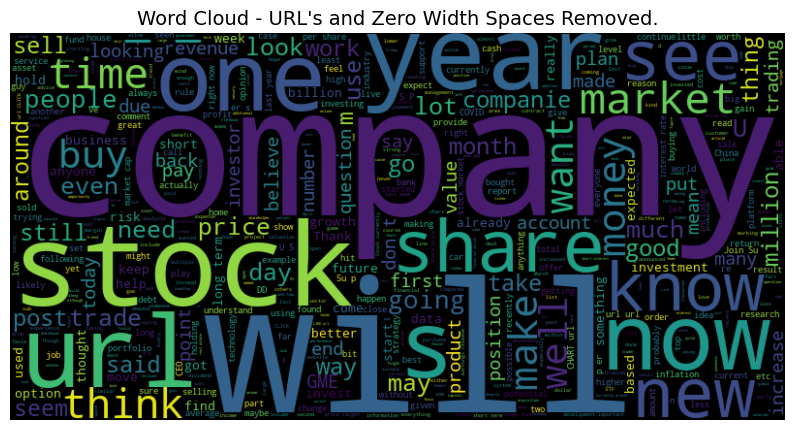

In [27]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).apply(lambda x: re.sub(r'x200B', '', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's and Zero Width Spaces Removed.", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

What are common selftext values, and how should they be handled?

In [28]:
df['selftext'].value_counts().iloc[:5]

selftext
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

This contains recurring discussion posts and self_text values of '[deleted]' which should be removed.

In [29]:
df.shape, df[df['selftext']!='[deleted]'].shape

((25971, 25), (25575, 25))

### Removing Discussion Posts

In [30]:
text_frequency = df['selftext'].value_counts().reset_index()
text_frequency = text_frequency[text_frequency['count']>3]
discussion_posts = text_frequency['selftext'].tolist()
df[df['selftext'].isin(discussion_posts)].iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
369,369,o64ihd,PennyBotWeekly,2021-06-23 03:25:12,2021-06-23 10:11:01,1970-01-01 00:00:00,0,0,0,0,...,Megathread,0.91,0,0,74,0,THE LOUNGE and DAILY PLAYS Megathreads are now integrated into a single Megathread!!!!!\n\nIn an...,self,https://redd.it/o64ihd,8
5077,7053,pcjlxl,AutoModerator,2021-08-27 09:00:15,2021-08-27 17:18:21,1970-01-01 00:00:00,0,0,0,0,...,NaN,0.67,0,0,26,0,\n\nPlease use this thread to discuss how amazingly cheap you are. How do you keep your costs...,self,https://redd.it/pcjlxl,3


# Cleaning Data

### Drop NA's

In [31]:
df = df.dropna(subset='selftext')

### Fill NA's

In [32]:
df = df.fillna({'link_flair_text':''})

### Remove [deleted] selftext entries

In [33]:
df = df[df['selftext']!='[deleted]']

### Remove discussion posts

In [34]:
def remove_discussion_posts(df_orig):
    '''Discussion posts are defined as posts that occur more than 3 times.'''
    df = df_orig.copy()

    text_frequency = df['selftext'].value_counts().reset_index()
    text_frequency = text_frequency[text_frequency['count']>3]
    discussion_posts = text_frequency['selftext'].tolist()
    
    df = df[~df['selftext'].isin(discussion_posts)]


    return df

# df = remove_discussion_posts(df)

### Preprocess data and clean data
We must remove excess HTML and other words.

In [35]:
unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
df = df.drop(columns=unnamed_columns)

We must remove excess HTML and other words.

In [36]:
def preprocessor(text):
    try:
        text = re.sub('<[^>]*>', '', text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                               text)
        text = (re.sub('[\W]+', ' ', text.lower()) +
                ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    text = str(text).lower()
    text = re.sub(r'#(\w+)', r'<\1>', text)
    text = re.sub(r'\n', ' ', text) # Remove /n
    text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
    text = re.sub(r'RT\s+', '', text) # Remove RT
    text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
    text = re.sub('x200B', '', text)
    return text

# There's a chance we WON'T need to convert emojis to text if the model we're using supports emojis, but this might be useful
def deemoji_text(text):
    return emoji_demojize(text)

def deemoji_text_unicode(text):
    return text.encode('unicode-escape').decode('utf-8')

def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+')
    return url_pattern.sub('', text)

def drop_unnamed_columns(df_orig):
    df = df_orig.copy()
    unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df_full.drop(columns=unnamed_columns)
    return df

In [37]:
df['selftext'] = df['selftext'].apply(cleaner).apply(preprocessor)

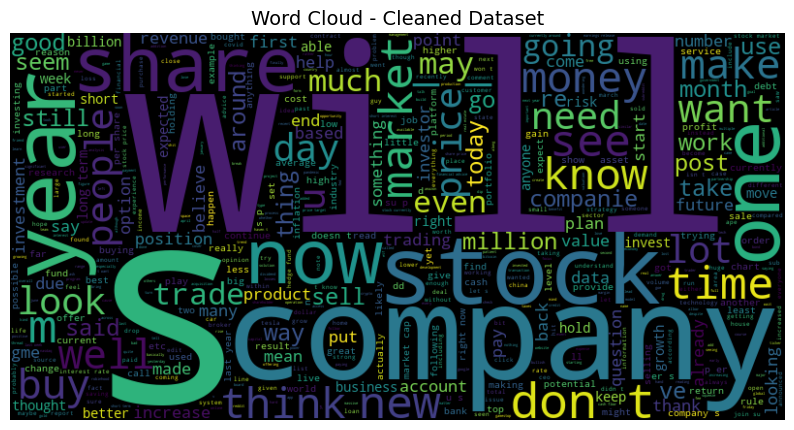

In [38]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'] )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - Cleaned Dataset", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

# Standardizing Numeric Fields

### Examine Numeric Fields

In [39]:
numeric_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.values
df[numeric_columns]

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score
12827,0,0,0,0,0,1,0,0,0.81,0,0,1,0,6
2075,0,0,0,0,0,1,0,0,0.96,1,16,601,1,7030
15922,0,0,0,0,0,1,0,0,0.97,0,0,47,0,78
369,0,0,0,0,0,1,0,0,0.91,0,0,74,0,8
2546,0,0,0,0,0,1,0,0,0.71,0,1,18,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10062,0,0,0,0,0,1,0,0,0.85,0,0,17,0,80
9865,0,0,0,0,0,1,0,0,0.92,0,0,3,0,9
1792,0,0,0,0,0,1,0,0,0.92,0,0,3,0,10
11353,0,0,0,0,0,1,0,0,0.78,0,0,14,0,5


### Scale Numeric Fields

In [40]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']

non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

In [41]:
scaler = StandardScaler()

df_scaled_values = scaler.fit_transform(df[scaling_fields].values)

df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)

In [42]:
df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)

In [43]:
df_std.iloc[1:3]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,selftext,thumbnail,shortlink,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
1,lblofg,lenz1002,2021-02-03 11:35:03,2021-02-04 22:02:21,2021-02-03 15:19:30,0,0,0,0,0,...,Discussion,it s not rocket science robinhood s imposed buy limits coincide perfectly with gme s stock plumm...,self,https://redd.it/lblofg,0.930879,5.293802,1.370474,1.681270,0.577142,1.695511
2,ktf2ah,Brothanogood,2021-01-08 23:48:56,2021-02-03 21:18:08,1970-01-01 00:00:00,0,0,0,0,0,...,News,roblox said earlier this week that it raised 520 million in private capital ahead of a direct li...,self,https://redd.it/ktf2ah,0.981162,-0.015552,-0.036022,-0.086669,-0.020217,-0.126987


# Full Dataset Cleaning and Training/Validation/Test Assignments

In [44]:
df_full = df_full.dropna(subset='selftext')

In [45]:
df_full = df_full.fillna({'link_flair_text':''})

In [46]:
df_full = df_full[df_full['selftext']!='[deleted]']

In [47]:
def remove_discussion_posts(df_orig):
    '''Discussion posts are defined as posts that occur more than 3 times.'''
    df = df_orig.copy()

    text_frequency = df['selftext'].value_counts().reset_index()
    text_frequency = text_frequency[text_frequency['count']>3]
    discussion_posts = text_frequency['selftext'].tolist()
    
    df = df[~df['selftext'].isin(discussion_posts)]


    return df

In [48]:
# df = remove_discussion_posts(df)

### Clean and Preprocess Data

In [49]:
df_full['selftext'] = df_full['selftext'].apply(cleaner).apply(preprocessor)

### Drop Columns containing "Unnamed"

In [50]:
df_full = drop_unnamed_columns(df_full)

### Scale Numeric Fields

In [51]:
def scale_numeric_fields(scaler, df, scaling_fields):
    non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

    df_scaled_values = scaler.fit_transform(df[scaling_fields].values)
    df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)
    
    df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)
    
    return df_std

In [52]:
scaler = StandardScaler()

df_full = scale_numeric_fields(scaler, df_full, scaling_fields)

### Split Data into Train, Validation, Test sets

In [53]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[['id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink']]

    Y_full = df_full['score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0])
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [54]:
# X_train.to_csv('./data/X_train.csv')
# y_train.to_csv('./data/y_train.csv')

# X_val.to_csv('./data/X_val.csv')
# y_val.to_csv('./data/y_val.csv')

# X_test.to_csv('./data/X_test.csv')
# y_test.to_csv('./data/y_test.csv')